<a href="https://colab.research.google.com/github/vikrant65-byte/Image_segmentation_for-_self_driving_cars/blob/main/image_segmentation_for_self_driving_cars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Image Segmentation for Self-Driving Cars</h1>

Hi and welcome to my notebook explaining the basics about image segmentation for self-driving cars. Image segmentation is an exciting toptic that allows computers to classify regions of images as certain objects - an important task for self-driving cars.

<h3>Importing the required libraries</h3>
First of all we have to import the required libraries.
<ul>
    <li>Numpy - for linear algebra</li>
    <li>os - for receiving information about files</li>
    <li>matplotlib - for visualizing</li>
    <li>PIL and CV2 - for image loading and editing</li>
    <li>scikit-learn KMeans - for color clustering</li>
    <li>random - for generating random numbers and choices</li>
    <li>keras - a high level interface to tensorflow (for neural networks)</li>
</ul>

In [ ]:
pip install --upgrade pip

  Attempting uninstall: pip
    Found existing installation: pip 20.2.3
    Uninstalling pip-20.2.3:
      Successfully uninstalled pip-20.2.3
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
 pip install opencv-python

     ---------------------------------------- 35.4/35.4 MB 2.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
 pip install --user  tensorflow

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


  Using cached tensorflow-2.8.0-cp39-cp39-win_amd64.whl (438.0 MB)
     -------------------------------------- 895.7/895.7 KB 2.3 MB/s eta 0:00:00
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
     ---------------------------------------- 3.4/3.4 MB 2.3 MB/s eta 0:00:00
  Using cached absl_py-1.0.0-py3-none-any.whl (126 kB)
     ---------------------------------------- 13.9/13.9 MB 2.2 MB/s eta 0:00:00
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
     ---------------------------------------- 14.7/14.7 MB 2.3 MB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 2.4 MB/s eta 0:00:00
     ---------------------------------------- 5.8/5.8 MB 2.0 MB/s eta 0:00:00
  Using cached termcolor-1.1.0.tar.gz (3.9 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---

In [1]:
!pip install cv2
!pip install keras
!pip install tensorflow
!pip install sklearn

ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


In [2]:
import numpy as np # linear algebra
import os
import matplotlib.pyplot as plot
from PIL import Image
import cv2
from sklearn.cluster import KMeans
import random

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Conv2D, MaxPooling2D, Dense, Dropout, LeakyReLU, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam,SGD # - Works

#from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint

<h3>LoadImage</h3>
The function LoadImage loads and image from a file path and also allows simpe data augmentation options such as flipping and rotating. The images are side-by-side images of the raw image and a color coded segmented image. The function splits the image into seperate images and cuts the engine hood away.

In [ ]:
def LoadImage(name, path="D:/Downloads/archive (4)/cityscapes_data/train",
             rotation=0.0, flip=False, cut_bottom=58,
             size=(256, 200)):
    img = Image.open(path+"/"+name)
    img = np.array(img)
    seg = img[:-cut_bottom, 256:]
    img = img[:-cut_bottom, 0:256]
    
    for i in range(3):
        zimg = img[:,:,i]
        zimg = cv2.equalizeHist(zimg)
        img[:,:,i] = zimg
    
    img = Image.fromarray(img).resize(size)
    seg = Image.fromarray(seg).resize(size)
    
    

    img = img.rotate(rotation)
    seg = seg.rotate(rotation)

    img = np.array(img)
    seg = np.array(seg)

    if flip:
        img = img[:,::-1,:]
        seg = seg[:,::-1,:]

        #seg = np.round(seg/255.0)
    
    return img/255, seg/255

<h3>Color clustering</h3>
Due to the compression of the JPEG standard, there are more than only a few discrete colors in the segmented image. To find the most imortant colors and identify similar colors we can use KMeans clustering. This also allows us to go from a color representation to a class representation.

In [ ]:
files =os.listdir("D:/Downloads/archive (4)/cityscapes_data/train")[0:10]

colors = []
for file in files:
    img, seg = LoadImage(file)
    colors.append(seg.reshape(seg.shape[0]*seg.shape[1], 3))
colors = np.array(colors)
colors = colors.reshape((colors.shape[0]*colors.shape[1],3))

km = KMeans(13)
km.fit(colors)

KMeans(n_clusters=13)

<h3>Layers to RGB Image</h3>
After clustering the image contains information about 13 different layers. Computer displays can only utilize the RGB colorspace. This function converts the layer representation to a color representation. This is just for visualizing.

In [ ]:
def LayersToRGBImage(img):
    colors = [(255,0,0), (0,255,0), (0,0,255),
             (255,255,0), (255,0,255), (0,255,255),
             (255,255,255), (200,50,0),(50,200,0),
             (50,0,200), (200,200,50), (0,50,200),
             (0,200,50), (0,0,0)]
    
    nimg = np.zeros((img.shape[0], img.shape[1], 3))
    for i in range(img.shape[2]):
        c = img[:,:,i]
        col = colors[i]
        
        for j in range(3):
            nimg[:,:,j]+=col[j]*c
    nimg = nimg/255.0
    return nimg

<h3>Colors to Class</h3>
This function converts the discrete color representation (output of the color clustering) to a 13-dimensional class representation. This is useful for the machine learning algorithm later on. On the bottom you can see an example classification layed over the raw image.

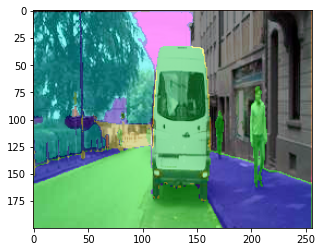

In [ ]:
def ColorsToClass(seg):
    s = seg.reshape((seg.shape[0]*seg.shape[1],3))
    s = km.predict(s)
    s = s.reshape((seg.shape[0], seg.shape[1]))
    
    n = len(km.cluster_centers_)
    
    cls = np.zeros((seg.shape[0], seg.shape[1], n))
    
    for i in range(n):
        m = np.copy(s)
        m[m!=i] = 0
        m[m!=0] = 1
        
        cls[:,:,i]=m
        
    return cls

img, seg = LoadImage("174.jpg")
seg2 = ColorsToClass(seg)
seg2 = LayersToRGBImage(seg2)
total = cv2.addWeighted(img, 0.6, seg2, 0.4, 0)
plot.imshow(total[:,:,:])
plot.show()

<h3>The Data Generator</h3>
To make training more memory efficient a generator is used for feeding the data to the deep learning algorithm. This generator creates batches of e.g. 10 raw-segmented image pairs at a time. It also uses image augmentation and randomly flips and rotates the images to increase the effective size of the dataset.

At the bottom you can see one such pair.

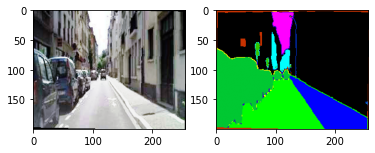

In [ ]:
def Generate(path="D:/Downloads/archive (4)/cityscapes_data/train", batch_size=10,
            maxangle=10.0):
    
    files = os.listdir(path)
    while True:
        imgs=[]
        segs=[]
        
        for i in range(batch_size):
            file = random.sample(files,1)[0]
            
            flip=False
            if random.random() > 0.5:
                flip=True
            
            angle = maxangle*(random.random()*2-1)
            
            img, seg = LoadImage(file, path, rotation=angle, flip=flip)
            
            seg = ColorsToClass(seg)
            
            imgs.append(img)
            segs.append(seg)
        yield np.array(imgs), np.array(segs)
        
gen = Generate()
imgs, segs = next(gen)

plot.subplot(121)
plot.imshow(imgs[0])
plot.subplot(122)
plot.imshow(LayersToRGBImage(segs[0]))
plot.show()

<h3>The Convolutional Neural Network - UNet</h3>
For learning we are building a UNet type network. This is a special kind of CNN, which uses concatenate layers to feed data from previous layers to the layers close to the output. The network has a double-funnel shape. The throughfeeding of data makes sure that no data is lost. Otherwise the funnel shape would cause something similar to an autoencoder.

In [ ]:
inp = Input(shape=(200, 256, 3))

x1 = BatchNormalization()(inp)
x1 = Conv2D(64, 12, activation="relu", padding="same")(x1)
x1 = Conv2D(128, 12, activation="relu", padding="same")(x1)
p1 = MaxPooling2D()(x1)
#p1 = Dropout(0.2)(p1)

#x2 = BatchNormalization()(x1)
x2 = Conv2D(128, 9, activation="relu", padding="same")(p1)
x2 = Conv2D(128, 9, activation="relu", padding="same")(x2)
p2 = MaxPooling2D()(x2)
#p2 = Dropout(0.2)(p2)

#x3 = BatchNormalization()(x2)
x3 = Conv2D(128, 6, activation="relu", padding="same")(p2)
x3 = Conv2D(128, 6, activation="relu", padding="same")(x3)
p3 = MaxPooling2D()(x3)
#p3 = Dropout(0.2)(p3)

#x4 = BatchNormalization()(x3)
x4 = Conv2D(128, 3, activation="relu", padding="same")(p3)
x4 = Conv2D(128, 3, activation="relu", padding="same")(x4)
#x4 = MaxPooling2D()(x4)
#x4 = Dropout(0.2)(x4)

x5 = UpSampling2D()(x4)
x5 = concatenate([x3, x5])
x5 = Conv2D(128, 6, activation="relu", padding="same")(x5)
x5 = Conv2D(128, 6, activation="relu", padding="same")(x5)
#x5 = Dropout(0.2)(x5)

x6 = UpSampling2D()(x5)
x6 = concatenate([x2, x6])
x6 = Conv2D(128, 6, activation="relu", padding="same")(x6)
x6 = Conv2D(128, 6, activation="relu", padding="same")(x6)
#x6 = Dropout(0.2)(x6)

x7 = UpSampling2D()(x6)
x7 = concatenate([x1, x7])
x7 = Conv2D(13, 6, activation="relu", padding="same")(x7)
x7 = Conv2D(13, 6, activation="softmax", padding="same")(x7)



model = Model(inp, x7)

opt = Adam(lr=0.0001)
model.compile(optimizer=opt,
             loss="categorical_crossentropy",
             metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 200, 256, 3)  12         ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 200, 256, 64  27712       ['batch_normalization[0][0]']    
                                )                                                             

D:\Python-projects\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


The network has 9 million trainable parameters.

The next step is to create two generators:
<ul>
    <li>Training generator - for training data</li>
    <li>Validation generator - to prevent overfitting</li>
    </ul>

In [ ]:
train_gen = Generate()
val_gen = Generate("D:/Downloads/archive (4)/cityscapes_data/val")

<h3>Training</h3>

Finally we can start training. We will train for 1000 epochs and use a Model Checkpoint to save the model with the smalles validation loss.

In [ ]:
clb = [ModelCheckpoint("loss.h5", save_best_only=True, verbose=0)]

h = model.fit_generator(train_gen, epochs=1000, steps_per_epoch=10,
                       validation_data=val_gen, validation_steps=10,
                       callbacks=clb, verbose=0)

C:\Users\USER\AppData\Local\Temp/ipykernel_19776/1169847173.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  h = model.fit_generator(train_gen, epochs=1000, steps_per_epoch=10,


Time to save the model and load the best model from the training run.

In [ ]:
model.save("model.h5")
model = load_model("loss.h5")

We can now visualize the training by looking at the validation loss and validation accuracy.

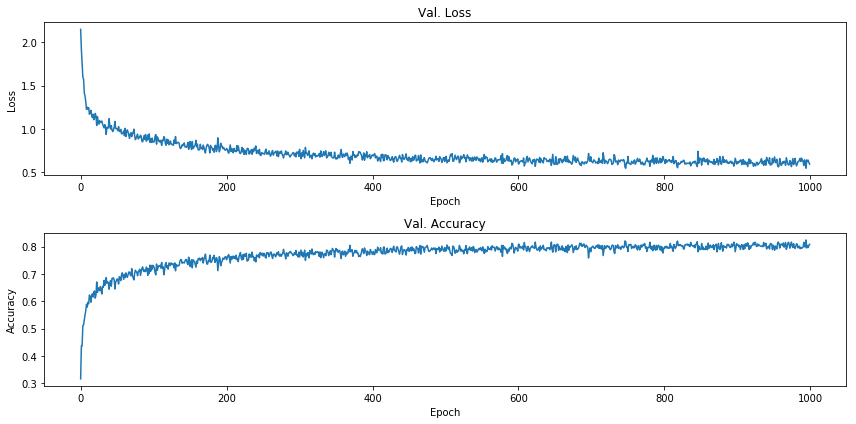

In [ ]:
loss = h.history["val_loss"]
acc = h.history["val_acc"]

plot.figure(figsize=(12, 6))
plot.subplot(211)
plot.title("Val. Loss")
plot.plot(loss)
plot.xlabel("Epoch")
plot.ylabel("Loss")

plot.subplot(212)
plot.title("Val. Accuracy")
plot.plot(acc)
plot.xlabel("Epoch")
plot.ylabel("Accuracy")

plot.tight_layout()
plot.savefig("learn.png", dpi=150)
plot.show()

<h3>The Results</h3>

We can now visualize how the CNN performs at the example of a few validation images. To be really sure there is no overfitting one could also have split of a test set from the training set.

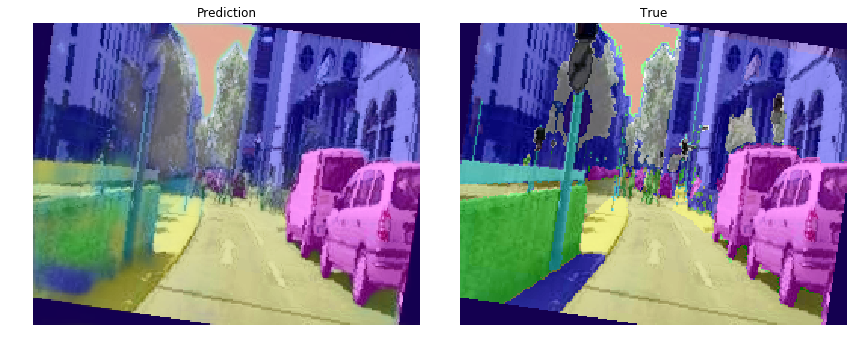

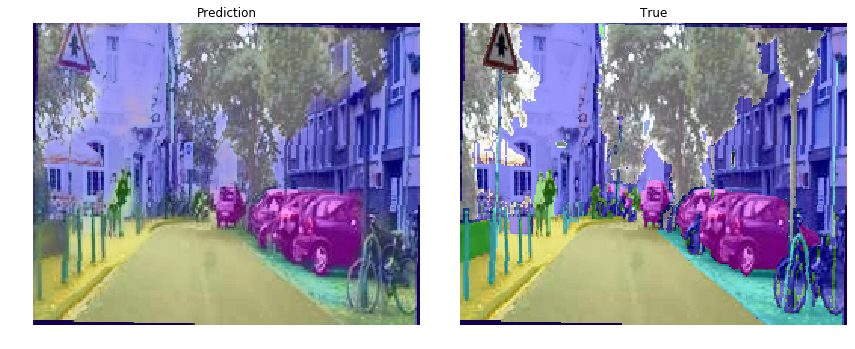

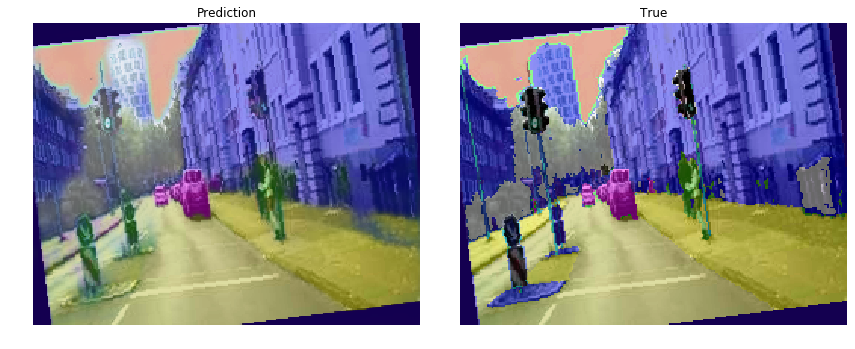

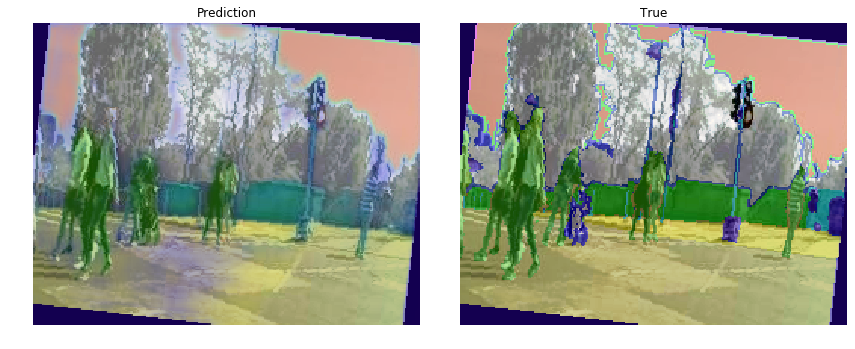

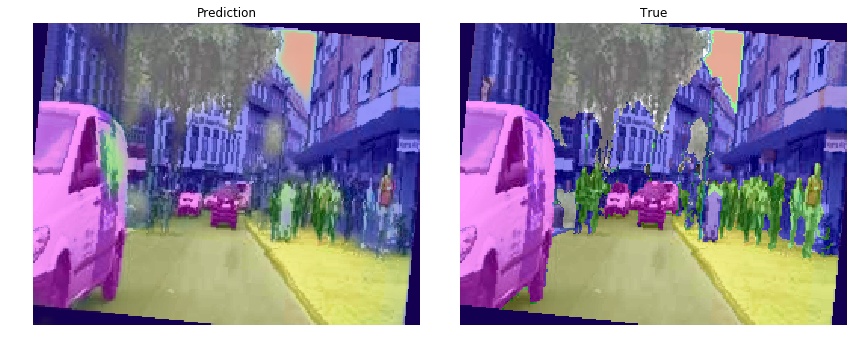

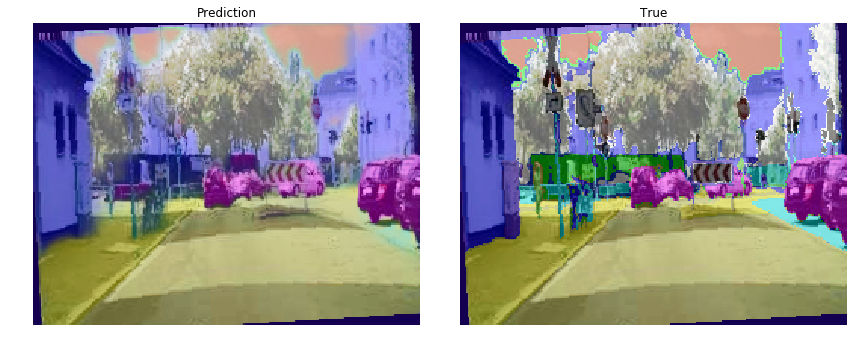

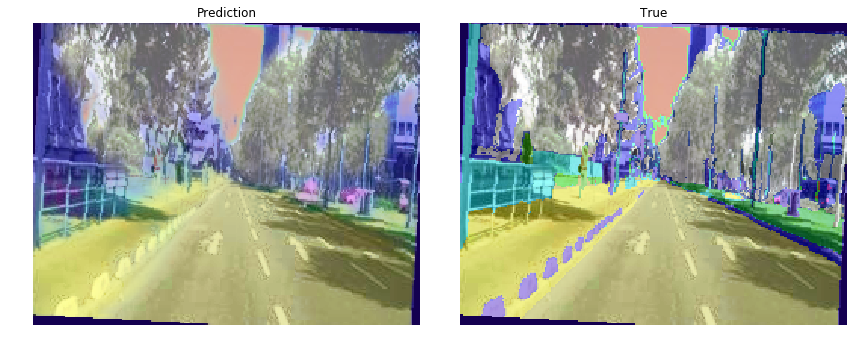

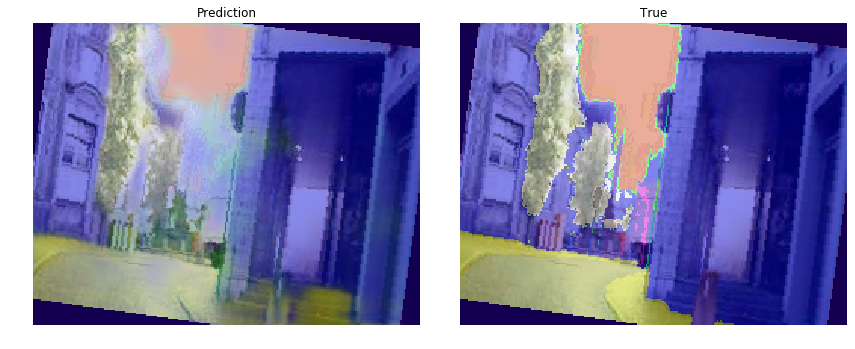

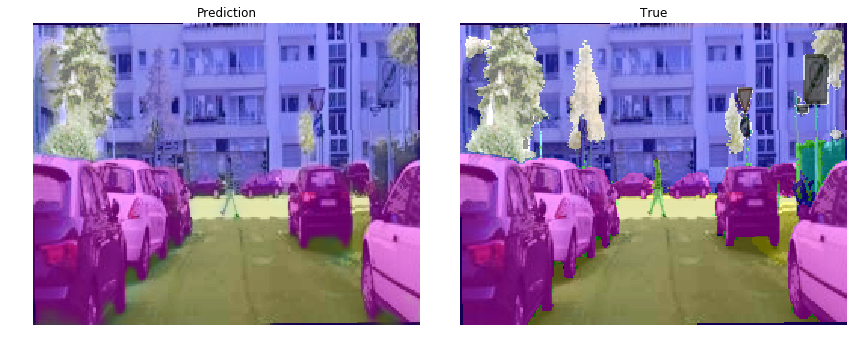

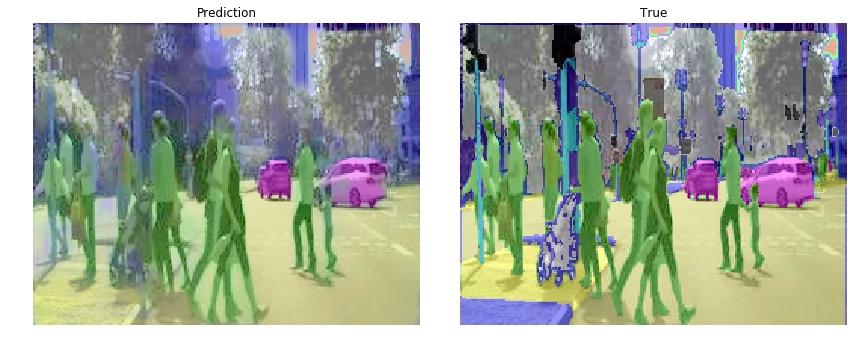

In [ ]:
test_gen = Generate("D:/Downloads/archive (4)/cityscapes_data/val")
max_show=20
for imgs, segs in test_gen:
    p = model.predict(imgs)
    for i in range(p.shape[0]):
        if i > max_show:
            break
        _p = LayersToRGBImage(p[i])
        _s = LayersToRGBImage(segs[i])
        
        predimg = cv2.addWeighted(imgs[i], 0.6, _p, 0.4, 0)
        trueimg = cv2.addWeighted(imgs[i], 0.6, _s, 0.4, 0)
        plot.figure(figsize=(12,6))
        plot.subplot(121)
        plot.title("Prediction")
        plot.imshow(predimg)
        plot.axis("off")
        plot.subplot(122)
        plot.title("True")
        plot.imshow(trueimg)
        plot.axis("off")
        plot.tight_layout()
        plot.savefig("pred_"+str(i)+".png", dpi=150)
        plot.show()
    break

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


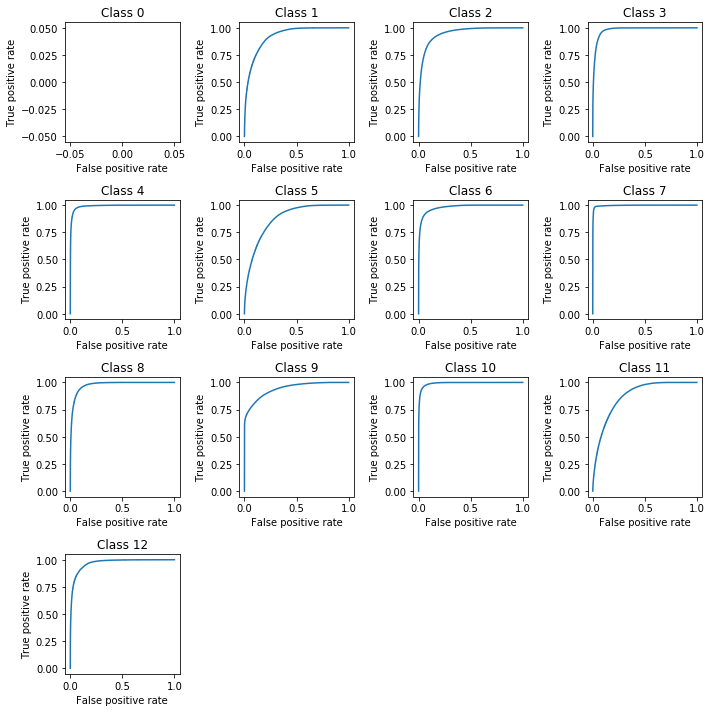

In [ ]:
from sklearn.metrics import roc_curve, balanced_accuracy_score
test_gen = Generate("D:/Downloads/archive (4)/cityscapes_data/val", batch_size=200)
max_show=20

bass = []

for imgs, segs in test_gen:
    p = model.predict(imgs)
    
    plot.figure(figsize=(10, 10))
    for i in range(p.shape[-1]):
        fpr, tpr, _ = roc_curve(segs[:,:,:,i].ravel(), p[:,:,:,i].ravel())
        
        _p = np.round(p[:,:,:,i].ravel()).astype(np.int32)
        bas = balanced_accuracy_score(segs[:,:,:,i].ravel(), _p)
        
        bass.append(bas)
        
        plot.subplot(4,4,i+1)
        plot.plot(fpr, tpr)
        plot.title("Class "+str(i))
        plot.xlabel("False positive rate")
        plot.ylabel("True positive rate")
    
    plot.tight_layout()
    plot.show()
    
    break

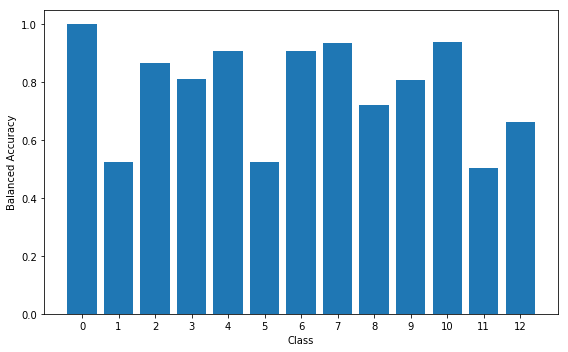

In [ ]:
plot.figure(figsize=(8, 5))
plot.bar(np.arange(0, len(bass)), bass)
plot.xticks(np.arange(0, len(bass)))
plot.ylabel("Balanced Accuracy")
plot.xlabel("Class")
plot.tight_layout()
plot.savefig("bas.png")
plot.show()

I hope you enjoyed reading this short notebook demonstrating how to implement a simple image segmentation model for self-driving cars!